In [35]:
spark.stop()

In [2]:
#0 Docker, 1 CloudVeneto
FIGHTER = 1

# la porta dove vedere i jobs 
SparkUI = 4041
# nicolò 4040
# marco  4041
# francesco 4042
# raffaele  4043

user = 'user_a'
core = 4
Npartition = 8

In [9]:
import os
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, TimestampType, BooleanType, StringType

from pyspark.sql.functions import (
    coalesce, corr, array,
    col, lit, expr, when, count, count_if, row_number, sum as spark_sum, abs as spark_abs,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg,
    first, last, lag, lead, row_number, desc, asc, bool_or, floor,
    explode, sequence, from_unixtime, to_date, unix_timestamp,
    window, min_by, mode, concat, monotonically_increasing_id
)

import datetime

In [7]:
if FIGHTER==0:

    spark = SparkSession.builder \
        .master("spark://spark-master:7077") \
        .appName("ProjectDocker") \
        .config("spark.executor.memory", "1000m") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
        .getOrCreate()

        # SE NON FUNZIONA TOGLI I DUE CONFIG DI ARROW

        # .config("spark.executor.memory", "1500m")
        # .config("spark.executor.cores", "1")\
        # .config("spark.executor.instances", "12")\
        # .config("spark.cores.max", "12")\
        # .config("spark.default.parallelism", "24")\
        # .config("spark.sql.adaptive.enabled", "true")\

elif FIGHTER==1:

        os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
        os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"
        
        spark = SparkSession.builder \
            .appName("ProjectCloudVeneto") \
            .master("spark://10.67.22.135:7077") \
            .config("spark.scheduler.mode", "FAIR") \
            .config("spark.scheduler.pool", user) \
            .config("spark.scheduler.allocation.file", "file:///usr/local/spark/conf/fairscheduler.xml") \
            .config("spark.cores.max", core) \
            .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
            .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
            .config("spark.dynamicAllocation.enabled", "false") \
            .config("spark.shuffle.service.enabled", "false") \
            .config("spark.ui.port", SparkUI) \
            .getOrCreate()
    
else : print("Better choose an available fighter, you little bastard.")

sc = spark.sparkContext

In [5]:
# if FIGHTER==0:
#     df = spark.read.option("header", True).option("inferSchema", True).csv("/ProvePreliminari/SW-106.csv")

# elif FIGHTER==1:
#     df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv")

# else:
#     print("Better choose an available fighter, you little bastard")

# df = df.repartition(Npartition)

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

def ROC_ScoreDF(df):

    #Filters all the blockID such that there is at least 1 anomaly
    AnomalousBlocks_df = (
        df
        .groupBy("BlockID")
        .agg(F.max("HasAnomaly").alias("HasAnomalyFlag"))
        .filter(F.col("HasAnomalyFlag") == 1)
        .select("BlockID"))

    #Filter the initial dataframe with only the anomalous blocks
    AnomDF = df.join(AnomalousBlocks_df, on="BlockID", how="inner")

    #BlockID of anomalous blocks 
    AnomalousBlocks = [row["BlockID"] for row in AnomDF.select("BlockID").distinct().collect()]

    #Computes the number of distinct value for all the metrics in the anomalous dataframe
    Metrics = ChangingMetrics(AnomDF)

    results = []

    #debug 
    AnomalousBlocks = [29]

    #Main loop over all the anomalous block
    for block in AnomalousBlocks:

        sensors = SpecificMetric(Metrics, block, 10)

        #Filter only the current block
        BlockDF = AnomDF.filter(F.col("BlockID") == block)

        HasAnomCol = BlockDF.select("HasAnomaly").collect()
        
        for sensor in sensors:

            print(f'({block}, {sensor})')
            SensorCol = BlockDF.select(sensor).collect()
            
            score = roc_auc_score(HasAnomCol, SensorCol)

            if score is not None:
                results.append((block, sensor, score))

    # Convert to DataFrame
    schema = ["BlockID", "Sensor", "ROC_AUC"]
    result_df = df.sparkSession.createDataFrame(results, schema=schema)

    return result_df
    

    
    

In [31]:
#test = ROC_ScoreDF(df_final)

25/08/09 07:23:36 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
25/08/09 07:23:40 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
                                                                                

(29, S10)
(29, S100)
(29, S101)
(29, S102)
(29, S107)
(29, S109)
(29, S122)
(29, S124)
(29, S126)
(29, S138)
(29, S140)
(29, S143)
(29, S147)
(29, S151)
(29, S154)
(29, S157)
(29, S158)
(29, S159)
(29, S164)
(29, S166)
(29, S178)
(29, S180)
(29, S37)
(29, S39)
(29, S40)
(29, S41)
(29, S46)
(29, S47)
(29, S5)
(29, S70)
(29, S71)
(29, S81)
(29, S83)
(29, S9)
(29, S90)
(29, S94)
(29, S97)


In [32]:
PandaDF = df_final.toPandas()

Anom = PandaDF[PandaDF['BlockID'] == 119]
Norm = PandaDF[PandaDF['BlockID'] == 118]

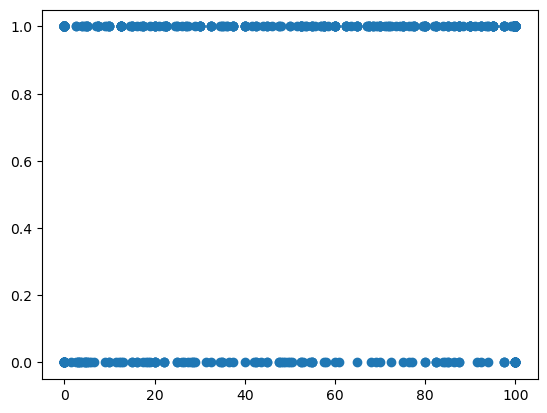

In [33]:
Complete = pd.concat([Norm, Anom])

HasAnom118 = np.zeros(len(Norm))
HasAnom119 = np.ones(len(Anom))
HasAnom = np.concatenate([HasAnom118, HasAnom119])

P10 = Complete['S10']

plt.scatter(P10, HasAnom)


In [34]:
from sklearn.metrics import roc_auc_score, roc_curve

score = roc_auc_score(HasAnom, P10)
score

0.576312910284464

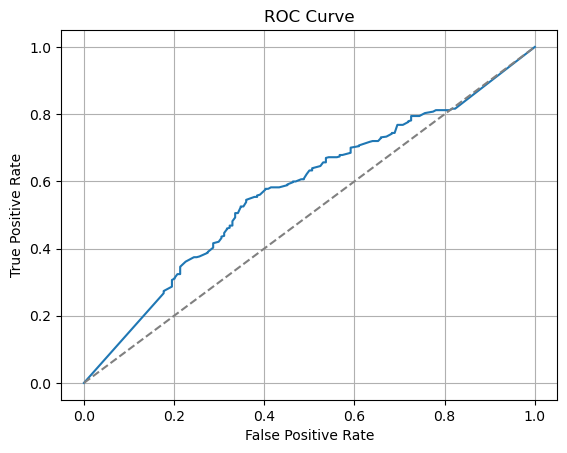

In [35]:
fpr, tpr, thresholds = roc_curve(HasAnom, P10)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # no-skill line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.show()

In [171]:
spark.stop()

# Unixtime (utile per controllare)

In [39]:
from datetime import datetime
print ( datetime.fromtimestamp(1601510430) )
print ( datetime.fromtimestamp(1601510550) )

2020-10-01 00:00:30
2020-10-01 00:02:30


# expr

In [31]:
data = [
    ("window1", 1, 10),
    ("window1", 0, 20),
    ("window2", 1, 30),
    ("window2", 1, 40),
]
columns = ["time_window", "A5", "A7"]

df_1 = spark.createDataFrame(data, columns)

print("DataFrame iniziale:")
df_1.show()


df_2 = df_1.agg(spark_avg(col("A7")).alias("media A7"))  #di fatto sottointeso .goupBy su tutto il dataframe
df_2.show()


df_3 = df_1.groupBy("time_window").agg(spark_avg(col("A7")).alias("media A7"))
df_3.show()

DataFrame iniziale:
+-----------+---+---+
|time_window| A5| A7|
+-----------+---+---+
|    window1|  1| 10|
|    window1|  0| 20|
|    window2|  1| 30|
|    window2|  1| 40|
+-----------+---+---+

+--------+
|media A7|
+--------+
|    25.0|
+--------+

+-----------+--------+
|time_window|media A7|
+-----------+--------+
|    window1|    15.0|
|    window2|    35.0|
+-----------+--------+



# agg

In [21]:
# 2. Creare il DataFrame di esempio
data = [
    ("window1", 1, 10),
    ("window1", 0, 20),
    ("window2", 1, 30),
    ("window2", 1, 40),
]
columns = ["time_window", "A5", "A7"]

df_windowed = spark.createDataFrame(data, columns)

print("DataFrame iniziale:")
df_windowed.show()

# 3. Definire le aggregazioni
aggs = [
    spark_max(col("A5")).alias("A5"),   # MAX per A5
    spark_avg(col("A7")).alias("A7")    # AVG per A7
]

# 4. Eseguire la groupBy con le aggregazioni
result_df = df_windowed.groupBy("time_window").agg(*aggs)

print("Risultato aggregato:")
result_df.show()

DataFrame iniziale:
+-----------+---+---+
|time_window| A5| A7|
+-----------+---+---+
|    window1|  1| 10|
|    window1|  0| 20|
|    window2|  1| 30|
|    window2|  1| 40|
+-----------+---+---+

Risultato aggregato:
+-----------+---+----+
|time_window| A5|  A7|
+-----------+---+----+
|    window2|  1|35.0|
|    window1|  1|15.0|
+-----------+---+----+



# window

In [11]:
# 2. Creiamo un DataFrame con timestamp + valori
data = [
    ("user1", 10, datetime.datetime(2023, 1, 1, 12, 0, 0)),
    ("user2", 20, datetime.datetime(2023, 1, 1, 12, 3, 0)),
    ("user1", 30, datetime.datetime(2023, 1, 1, 12, 7, 0)),
    ("user2", 40, datetime.datetime(2023, 1, 1, 12, 12, 0)),
    ("user1", 50, datetime.datetime(2023, 1, 1, 12, 18, 0)),
]

schema = StructType([
    StructField("user", StringType(), True),
    StructField("value", IntegerType(), True),
    StructField("timestamp", TimestampType(), True),
])

df = spark.createDataFrame(data, schema)

print("DataFrame originale:")
df.show(truncate=False)

# 3. Applichiamo una window di 10 minuti sul timestamp
df_windowed = (
    df.groupBy(window(col("timestamp"), "10 minutes"))  # ogni 10 minuti
      .agg(
          spark_avg("value").alias("avg_value"),
          count("*").alias("count")
      )
      .orderBy("window")
)

print("Aggregato per finestre di 10 minuti:")
df_windowed.show(truncate=False)

DataFrame originale:
+-----+-----+-------------------+
|user |value|timestamp          |
+-----+-----+-------------------+
|user1|10   |2023-01-01 12:00:00|
|user2|20   |2023-01-01 12:03:00|
|user1|30   |2023-01-01 12:07:00|
|user2|40   |2023-01-01 12:12:00|
|user1|50   |2023-01-01 12:18:00|
+-----+-----+-------------------+

Aggregato per finestre di 10 minuti:


[Stage 4:============================================>              (3 + 1) / 4]

+------------------------------------------+---------+-----+
|window                                    |avg_value|count|
+------------------------------------------+---------+-----+
|{2023-01-01 12:00:00, 2023-01-01 12:10:00}|20.0     |3    |
|{2023-01-01 12:10:00, 2023-01-01 12:20:00}|45.0     |2    |
+------------------------------------------+---------+-----+



In [14]:
# 2. Piccolo dataset con timestamp
data = [
    (1, datetime.datetime(2023, 1, 1, 12, 0, 0)),
    (2, datetime.datetime(2023, 1, 1, 12, 3, 0)),
    (3, datetime.datetime(2023, 1, 1, 12, 7, 0)),
    (4, datetime.datetime(2023, 1, 1, 12, 12, 0)),
]

schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("timestamp", TimestampType(), True),
])

df = spark.createDataFrame(data, schema)

print("DataFrame originale:")
df.show(truncate=False)

# 3. Usiamo SOLO la funzione window
df_windowed = df.select(window(col("timestamp"), "10 minutes").alias("time_window"))

print("DataFrame con le finestre temporali:")
df_windowed.show(truncate=False)

DataFrame originale:
+---+-------------------+
|id |timestamp          |
+---+-------------------+
|1  |2023-01-01 12:00:00|
|2  |2023-01-01 12:03:00|
|3  |2023-01-01 12:07:00|
|4  |2023-01-01 12:12:00|
+---+-------------------+

DataFrame con le finestre temporali:
+------------------------------------------+
|time_window                               |
+------------------------------------------+
|{2023-01-01 12:00:00, 2023-01-01 12:10:00}|
|{2023-01-01 12:00:00, 2023-01-01 12:10:00}|
|{2023-01-01 12:00:00, 2023-01-01 12:10:00}|
|{2023-01-01 12:10:00, 2023-01-01 12:20:00}|
+------------------------------------------+



In [ ]:
# {2023-01-01 12:00:00, 2023-01-01 12:10:00}
# in realtà è una struct con due campi: start e end.

In [18]:
df_estremi = df_windowed.select(col("time_window.start").alias("inizio"),col("time_window.end").alias("fine"))
df_estremi.show()

+-------------------+-------------------+
|             inizio|               fine|
+-------------------+-------------------+
|2023-01-01 12:00:00|2023-01-01 12:10:00|
|2023-01-01 12:00:00|2023-01-01 12:10:00|
|2023-01-01 12:00:00|2023-01-01 12:10:00|
|2023-01-01 12:10:00|2023-01-01 12:20:00|
+-------------------+-------------------+



In [34]:
spark.stop()